<a href="https://colab.research.google.com/github/hbisgin/DeepLearning/blob/main/DL_10_Q.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import *
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import make_moons
import time

In [3]:
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using.
        inputs = inputs.to(device)
        labels = labels.to(device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training: #check the flag
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy() # we have this info in the slides. Please remember why I am detaching
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()

    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem

    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

In [4]:
def train_simple_network2(model, loss_func, train_loader, test_loader=None, score_funcs=None,epochs=50, device="cpu", checkpoint_file=None):

    to_track = ["epoch", "total time", "train loss"] #Bookkeeping. These are what I want to track.

    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )

    total_train_time = 0 #How long have we spent in the training loop?
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device) #this will keep this in cpu unless you have GPU available and indicate it in the function call

    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [6]:
X_train, y_train = make_moons(n_samples=1000, noise=0.4)
X_test, y_test = make_moons(n_samples=200, noise=0.4)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
training_loader = DataLoader(train_dataset, shuffle=True)
testing_loader = DataLoader(test_dataset)

In [7]:
loss_func = nn.CrossEntropyLoss()

In [8]:
model = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
results_pd = train_simple_network2(model, loss_func, training_loader, epochs=5, test_loader=testing_loader, checkpoint_file='model.pt', score_funcs={'Acc':accuracy_score,'F1': f1_score})

Training:  95%|█████████▌| 953/1000 [00:01<00:00, 890.68it/s]
                                                             
Training:  94%|█████████▍| 941/1000 [00:00<00:00, 1319.70it/s]
                                                              
Training:  86%|████████▋ | 865/1000 [00:00<00:00, 1350.41it/s]
                                                              
Training:  96%|█████████▌| 961/1000 [00:00<00:00, 1278.62it/s]
                                                              
Training:  87%|████████▋ | 871/1000 [00:00<00:00, 1386.79it/s]
                                                              
Epoch: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


In [9]:
def visualize2DSoftmax(X, y, model, title=None):
    x_min = np.min(X[:,0])-0.5
    x_max = np.max(X[:,0])+0.5
    y_min = np.min(X[:,1])-0.5
    y_max = np.max(X[:,1])+0.5
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, num=20), np.linspace(y_min, y_max, num=20), indexing='ij')
    xy_v = np.hstack((xv.reshape(-1,1), yv.reshape(-1,1)))
    with torch.no_grad():
        logits = model(torch.tensor(xy_v, dtype=torch.float32))
        y_hat = F.softmax(logits, dim=1).numpy()

    cs = plt.contourf(xv, yv, y_hat[:,0].reshape(20,20), levels=np.linspace(0,1,num=20), cmap=plt.cm.RdYlBu)
    ax = plt.gca()
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, ax=ax)
    if title is not None:
        ax.set_title(title)

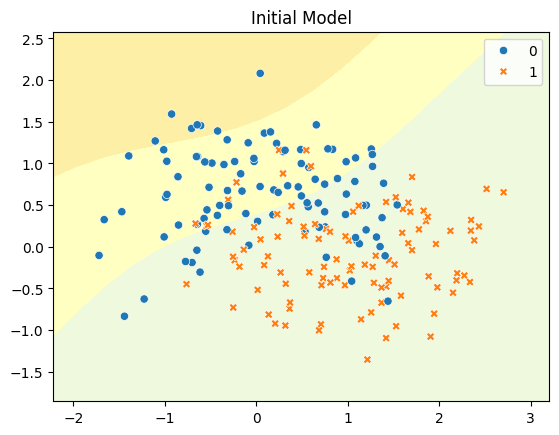

0.weight torch.Size([30, 2])
0.bias torch.Size([30])
2.weight torch.Size([30, 30])
2.bias torch.Size([30])
4.weight torch.Size([2, 30])
4.bias torch.Size([2])


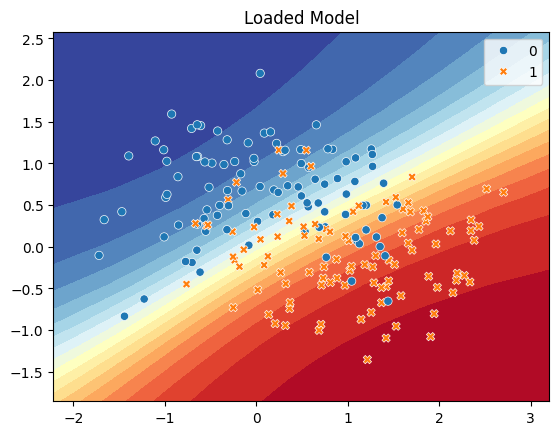

In [10]:
model_new = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
device = "cpu"

visualize2DSoftmax(X_test, y_test, model_new, title="Initial Model")
plt.show()

checkpoint_dict = torch.load('model.pt', map_location=device, weights_only=False)

for key, value in checkpoint_dict['model_state_dict'].items():
    print(key, value.shape)


model_new.load_state_dict(checkpoint_dict['model_state_dict'])

visualize2DSoftmax(X_test, y_test, model_new, title="Loaded Model")
plt.show()

<Axes: xlabel='epoch', ylabel='train Acc'>

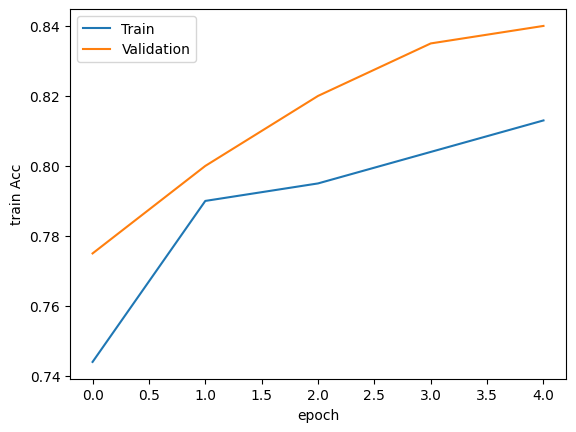

In [16]:
sns.lineplot(x='epoch', y='train Acc', data=results_pd, label='Train')
sns.lineplot(x='epoch', y='test Acc', data=results_pd, label='Validation')

<Axes: xlabel='total time', ylabel='train F1'>

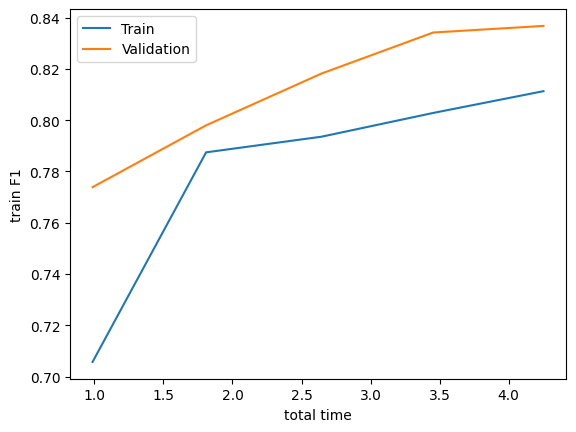

In [17]:
sns.lineplot(x='total time', y='train F1', data=results_pd, label='Train')
sns.lineplot(x='total time', y='test F1', data=results_pd, label='Validation')

In [18]:
training_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
model_gd = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
results_true_gd = train_simple_network2(model_gd, loss_func, training_loader, epochs=5, test_loader=testing_loader, checkpoint_file='model.pt', score_funcs={'Acc':accuracy_score,'F1': f1_score})

Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Testing:   0%|          | 0/1 [00:00<?, ?it/s]
                                              
Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Testing:   0%|          | 0/1 [00:00<?, ?it/s]
                                              
Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Testing:   0%|          | 0/1 [00:00<?, ?it/s]
                                              
Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Epoch: 100%|██████████| 5/5 [00:00<00:00, 22.54it/s]


<Axes: xlabel='total time', ylabel='test Acc'>

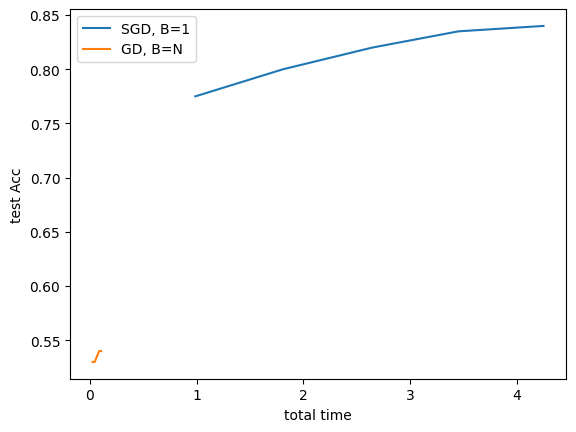

In [19]:
sns.lineplot(x='total time', y='test Acc', data=results_pd, label='SGD, B=1')
sns.lineplot(x='total time', y='test Acc', data=results_true_gd, label='GD, B=N')

In [20]:
training_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
model_sgd = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
results_batched = train_simple_network2(model_sgd, loss_func, training_loader, epochs=5, test_loader=testing_loader, checkpoint_file='model.pt', score_funcs={'Acc':accuracy_score,'F1': f1_score})

Training:   0%|          | 0/32 [00:00<?, ?it/s]
                                                
Training:   0%|          | 0/32 [00:00<?, ?it/s]
                                                
Training:   0%|          | 0/32 [00:00<?, ?it/s]
                                                
Training:   0%|          | 0/32 [00:00<?, ?it/s]
                                                
Training:   0%|          | 0/32 [00:00<?, ?it/s]
                                                
Epoch: 100%|██████████| 5/5 [00:00<00:00,  8.60it/s]


<Axes: xlabel='total time', ylabel='test Acc'>

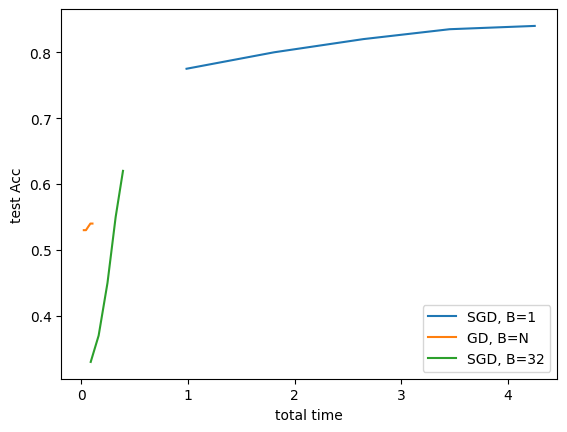

In [21]:
sns.lineplot(x='total time', y='test Acc', data=results_pd, label='SGD, B=1')
sns.lineplot(x='total time', y='test Acc', data=results_true_gd, label='GD, B=N')
sns.lineplot(x='total time', y='test Acc', data=results_batched, label='SGD, B=32')

#Exercise: please change the size of your data to something bigger and try an additional batch size to observe the total time vs. accuracy curves.